<a href="https://colab.research.google.com/github/gisalgs/notebooks/blob/main/computational_issues-colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Computational Issues of Spatial Indexing


>"How long does getting thin take?" asked Pooh anxiously.  
>"About a week, I should think."  
>"But I can't stay here for a *week*!"  
>"You can *stay* all right, silly old Bear. It's getting you out which is so difficult."
>
><cite>A. A. Milne, Winnie-the-Pooh</cite>

>"And is all this common consciousness satisfied to use me as a black box? Since the black box works, is it unimportant to know what is inside? --- That doesn't suit me. I don't enjoy being a black box. I want to know what's inside."
>
><cite>Issac Asimov, Foundation and Earth</cite>


The computational time for trees can be broken down to at least two parts. The first is the time used to construct the tree, and then it is the time the tree is used to query. The overall time complexity of building a balanced k-D tree is $O(n \log_2 n)$. Searching a k-D only takes $O(\log_2 n)$ time in average when the tree is balanced. For unbalanced trees, however, we can imagine a worst case where points are always aligned on one branch of the node and in this case the search time is $O(n)$, as same as the linear search (though the actual time might be longer because traversing a tree takes more time than traversing a list or an array).

For point quadtrees, the cost of building a point quadtree is $O(n \log_4 n)$ when points are randomly sorted before they are inserted to the tree as we discussed above. A simple search on a balanced point quadtree has a time complexity of $O(\log_4 n)$ while the worst case would be $O(n)$ when the tree has only one node at each depth.

The above discussion, however, is theoretical. In practice, the actual computational time may follow the overall trend as predicted, but there are also many other factors that have significant impacts on the performance. For example, the physical time used can vary a lot depending on whether the program is compiled into binary code (as C/C++ programs) or interpreted (as Python and Java). Generally speaking, interpreted programming languages such as Python are less efficient in terms of the actual running time because the code must be interpreted line by line. It should be noted that Python or Java is not the interpreted language in its original meaning where the interpreter literally goes through line by line for every time it runs the program. Instead, they often use an immediate representation of the code that is compiled in binary that runs faster. Still, interpreted languages are still generally slower than compiled languages such as C/C++. The difference may not be noticeable for small data (and probably we don't really care), but the difference will be big when we deal with large data sets.

Aside from the programming language, how the algorithms are actually implemented will be a factor too. For example, the use of recursive functions, as convenient as it is, slows down the algorithm because of the repeated recursive function calls.

The following are some commands that can be used in the notebook to get info about the system.

In [3]:
# Linux, Max, or Colab
!uname -a
print()
!lscpu

Linux e795f0eb5d6c 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4400.41
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 

In [4]:
# Windows
# !wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed

Also we can check the version of Python:

In [5]:
import sys
sys.version

'3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]'

## 1. Performance of query using k-D trees and point quadtrees

Here, we put our algorithms of k-D trees and point quadtrees into a test. We will simply compare the performance of using these trees, and we also compare them with the linear (brute-force) search approach. We test the performance by systematically controlling the size of the data and see how they catch up. The following are the packages that we will use.

In [6]:
# Uncomment the following if needed in Jupyter notebook to clone the github repos
!git clone https://github.com/gisalgs/geom.git
!git clone https://github.com/gisalgs/indexing.git

Cloning into 'geom'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 372 (delta 26), reused 6 (delta 2), pack-reused 314 (from 1)
Receiving objects: 100% (372/372), 94.58 KiB | 756.00 KiB/s, done.
Resolving deltas: 100% (203/203), done.
Cloning into 'indexing'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 177 (delta 1), reused 0 (delta 0), pack-reused 170 (from 1)
Receiving objects: 100% (177/177), 58.96 KiB | 838.00 KiB/s, done.
Resolving deltas: 100% (93/93), done.


In [7]:
from geom.point import *
from indexing.kdtree1 import *
from indexing.kdtree2a import *
from indexing.kdtree3 import *
from indexing.pointquadtree1 import *
from indexing.pointquadtree3 import *

from random import random, sample, uniform
import time
import copy

Now we write a function to do the testing. This function requires inputs of the number of points to be indexed in a tree, the number of points to be queried, and a boolean variable to specify if we need verbose (wordy) output.

## <font color="red">Question 1</font>

Complete the `# TODO` part below.

In [14]:
def test(npts, n, verbose=False):
    '''
    A function that evaluates the performance of four different types of search using
        1. a k-D tree based on the order of points that is given
        2. a balanced k-D tree
        3. a point quadtree based on the order of points that is given
        4. a brute-force approach (linear search)

    INPUT
        npts    - the number of points to be searched from
                    the actual points will be randomly generated
                    where the coordinates of each point range from 0 to 1
        n       - the number of points to be searched
                    the actual points to be searched will be randomly sampled from npts
        verbose - a boolean value (True - print out more info, False - no print out)
                    when True, print out the format as follows:
                        10000 |  0.135  0.050  0.065 |  0.001  0.001  0.001 |  0.073
                    where the numbers are npts, time to build k-D tree, the balanced k-D tree, and the point quadtree, and
                    time to search using the k-D tree, balanced k-D tree, point quadtree, and linear search, respectively.

    OUTPUT
        a tuple containing the 8 numbers mentioned above in the "verbose" section.

    Example

        >>> t1 = test(10000, 100, True)
          10000 |  0.135  0.050  0.065 |  0.001  0.001  0.001 |  0.073
        >>> print(t1)
        (10000, 0.13518762588500977, 0.04988360404968262, 0.0650629997253418, 0.0009088516235351562, 0.0006577968597412109, 0.0006163120269775391, 0.0731801986694336)
    '''
    # TODO: complete the code below

    points = [Point(random(), random()) for i in range(npts)]

    time1 = time.time()
    kdt1 = kdtree(points)
    time2 = time.time()
    treet1 = time2-time1

    time1 = time.time()
    qdt = pointquadtree(points)
    time2 = time.time()
    treet3 = time2-time1

    time1 = time.time()
    kdt2 = kdtree2(points)
    time2 = time.time()
    treet2 = time2-time1

    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    pp = sample(points, n)
    for p in pp:
      time1 = time.time()
      p1 = query_kdtree(kdt1,p)
      time2 = time.time()
      t1 += time2-time1

      time1 = time.time()
      p1 = query_kdtree(kdt2,p)
      time2 = time.time()
      t2 += time2-time1

      time1 = time.time()
      p1 = search_pqtree(qdt,p)
      time2 = time.time()
      t3 += time2-time1

      time1 = time.time()
      for i in range(len(points)):
        if p == points[i]:
          break
      time2 = time.time()
      t4 += time2-time1

    if verbose:
         print(f'{npts:7}  |  {treet1:6.3f}  |  {treet2:6.3f}  |    {treet3:6.3f}  |  {t1:6.3f}   {t2:6.3f}   {t3:6.3f}    {t4:6.3f}  ')
    return npts, treet1, treet2, treet3, t1, t2, t3, t4






Here is a quick demo of this function in searching for 100 random points from 10,000 points. The test() function has an input called verbose which can be used to make the function run silently without printing anything. But printing out the current result can be a good feature if we want to know how the program progresses during time (for a long wait).

In [15]:
t1 = test(10000, 100, True)

print(t1)

  10000  |   0.182  |   0.069  |     0.344  |   0.003    0.003    0.002     0.164  
(10000, 0.18244600296020508, 0.06913447380065918, 0.3435351848602295, 0.002948760986328125, 0.0028333663940429688, 0.0015308856964111328, 0.16361093521118164)


The above quick test clearly shows the efficiency of using the indexing method for query. It also shows that building the tree may need some significant amount of time.

Now we give it a more systematical test. More specifically, we use different numbers of points, ranging from 100,000 to **1,000,000**, with a step of 100,000. All the experiments were done on Now we give it a more systematical test. More specifically, we use different numbers of points, ranging from 100,000 to **1,000,000**, with a step of 100,000. The experiments will be done on different systems (local or cloud) and the numbers will be different.

In [16]:
%%time
time1 = time.time()
n = 100
alltime = []
for npts in range(100000, 1000001, 100000):
    alltime.append(test(npts, n, True))

time2=time.time()

 100000  |   2.976  |   1.644  |     2.536  |   0.006    0.003    0.002     3.129  
 200000  |   8.292  |   3.344  |     4.032  |   0.008    0.004    0.003     6.700  
 300000  |  12.393  |   5.651  |     5.466  |   0.007    0.004    0.003    11.116  
 400000  |  16.551  |   8.079  |     8.468  |   0.008    0.004    0.003    16.124  
 500000  |  21.073  |   9.846  |    10.858  |   0.008    0.004    0.003    18.868  
 600000  |  26.160  |  12.818  |    13.105  |   0.008    0.004    0.003    23.810  
 700000  |  31.081  |  14.043  |    16.044  |   0.008    0.004    0.003    29.019  
 800000  |  36.912  |  18.341  |    16.882  |   0.008    0.004    0.003    34.830  
 900000  |  42.370  |  18.347  |    20.112  |   0.009    0.004    0.003    34.634  
1000000  |  47.546  |  22.173  |    23.316  |   0.009    0.004    0.003    41.450  
CPU times: user 11min 55s, sys: 4.36 s, total: 11min 59s
Wall time: 12min 4s


The following code reports some numbers, including the total time in minutes and the time used on tree, where almost all of that time are used to construct the tree (so using the tree doesn't take much time).

In [17]:
t1 = (time2-time1)/60
t2 = sum([sum(alltime[i][1:]) for i in range(len(alltime))])/60
t3 = sum([sum(alltime[i][1:7]) for i in range(len(alltime))])/60
t4 = sum([sum(alltime[i][1:4]) for i in range(len(alltime))])/60
print(f'total computing time: {t1:.1f} minutes')
print(f'Total processing time: {t2:.1f} minutes')
print(f'Total time on trees: {t3:.1f} minutes')
print(f'Tree construction time: {t4:.1f} minutes')

total computing time: 12.1 minutes
Total processing time: 11.7 minutes
Total time on trees: 8.0 minutes
Tree construction time: 8.0 minutes


As a way of comparison, we can find [past results](https://github.com/gisalgs/notebooks/blob/main/computational-issues-past-results.md) at the github repo. It is interesting to see how performance varies among computers and even Python versions.


We now plot the results for a better visualization of the difference in the performances. Here is a shot at the construction times used for different kinds of trees:

In [18]:
sys.version_info

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

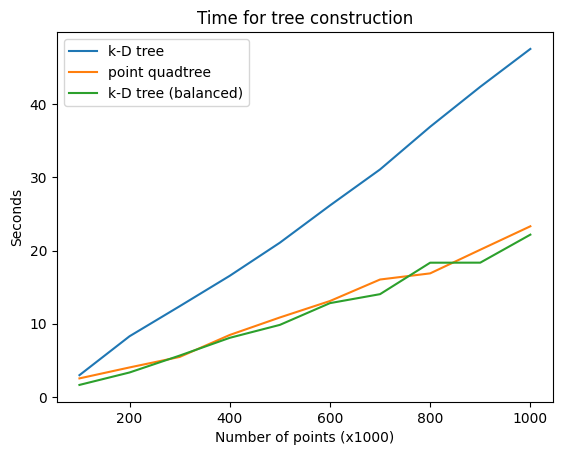

In [20]:
x = [ alltime[i][0]/1000 for i in range(len(alltime))]
plt.plot(x, [ alltime[i][1] for i in range(len(alltime))], label='k-D tree')
plt.plot(x, [ alltime[i][3] for i in range(len(alltime))], label = 'point quadtree')
plt.plot(x, [ alltime[i][2] for i in range(len(alltime))], label='k-D tree (balanced)')
plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Time for tree construction')
plt.show()

The benefit of using the tree for query is obvious:

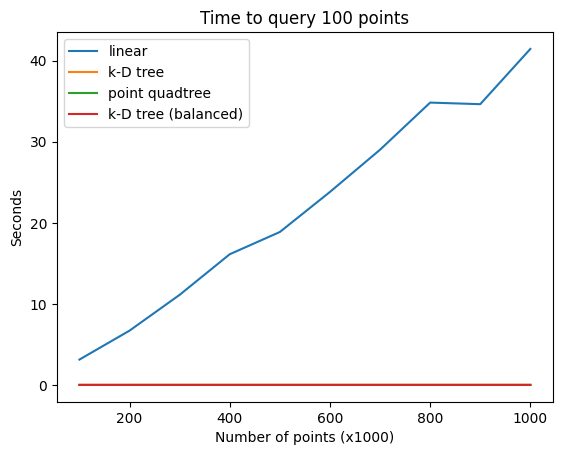

In [21]:
plt.plot(x, [ alltime[i][7] for i in range(len(alltime))], label='linear')
plt.plot(x, [ alltime[i][4] for i in range(len(alltime))], label='k-D tree')
plt.plot(x, [ alltime[i][6] for i in range(len(alltime))], label='point quadtree')
plt.plot(x, [ alltime[i][5] for i in range(len(alltime))], label='k-D tree (balanced)')
plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Time to query 100 points')
plt.show()

The trend of using the tree across the three trees is not clear based on the test we just did, but we can still see from below that the balanced k-D tree is clearly positioned at the bottom of the three curves, showing the efficiency of the balanced tree.

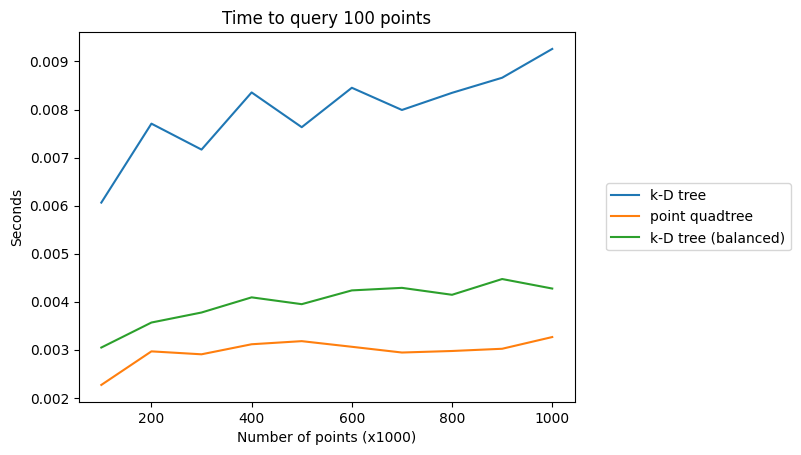

In [22]:
plt.plot(x, [ alltime[i][4] for i in range(len(alltime))], label='k-D tree')
plt.plot(x, [ alltime[i][6] for i in range(len(alltime))], label='point quadtree')
plt.plot(x, [ alltime[i][5] for i in range(len(alltime))], label='k-D tree (balanced)')
plt.legend(loc='upper left')
plt.xlabel('Number of points (x1000)')
plt.ylabel('Seconds')
plt.title('Time to query 100 points')
plt.legend(loc='right', bbox_to_anchor=(1.45, 0.5))
plt.show()

## 2. Performance of orthogonal range search

We first define a few functions to make it convenient for testing different cases.

A note on changes: the textbook (*GIS Algorithms*) has the following line to create random points.

`randpoints0 = [Point(randrange(xmin, xmax), randrange(ymin, ymax)) for i in range(npts)]`

However, `randrange` will only return integers which will likely produce duplicated points. Here we write a new function called `rand_point` that uses `random.uniform` to generate random points.

In [23]:
# A rectangle is defined as [ [xmin, xmax], [ymin, ymax]]

def in_rect(p, rect):
    x, y = p.x, p.y
    if not (rect[0][0]>x or rect[0][1] < x or rect[1][0]>y or rect[1][1] < y):
        return True
    return False

def rectangular_linear(points, rect):
    l = []
    for p in points:
        if in_rect(p, rect):
            l.append(p)
    return l

def rand_point(rect):
    '''
    Generates a random point within a rect.

    rect = [[xmin, xmax], [ymin, ymax]]
    '''
    x = uniform(rect[0][0], rect[0][1])
    y = uniform(rect[1][0], rect[1][1])
    return Point(x, y)

def test_rect_find(w=10, h=10, rect=[[10,1000], [10,1000]], npts=100, n_query=10):
    """
    Repeats n_query times, based on npts points.
    Points are random in a area with both x and y ranging  from 10 to 1000.

    Uses a balanced k-D tree.
    Same set of points are used for n_query times.
    Each time, find points in a tree of npts points in a rectangle of w wide and h high.
    The rectangle does not go out of the range of x and y.

    Returns times of using the k-D tree and linear search, respectively.
    The time is averaged per query.
    """
    randpoints0 = [rand_point(rect) for i in range(npts)]
    randpoints = copy.deepcopy(randpoints0)
    kdt = kdtree2(randpoints0)

    times = []
    for i in range(n_query):
        x1 = uniform(rect[0][0], rect[0][1]-w)
        y1 = uniform(rect[1][0], rect[1][1]-h)
        rect_target = [ [x1, x1+w], [y1, y1+h] ]
        t1 = time.time()
        found = []
        range_query_orthogonal(kdt, rect_target, found)
        t2 = time.time()
        found2 = rectangular_linear(randpoints, rect_target) # linear search
        t3 = time.time()
        times.append( (t2-t1, t3-t2))
    return sum([t[0] for t in times])/float(n_query), sum([t[1] for t in times])/n_query

Here is an example of using it:

In [24]:
test_rect_find(20, 20, npts=100000)

(0.0002372264862060547, 0.03349692821502685)

We hypothesize that using a k-D tree will help rectangular query, but the increase of the rectangle size will increase the time used to query. We test two things here:

1. when will the additional computation caused by the increase of the rectangle exceed the efficiency of using a k-D tree?
2. what is the impact of increasing the problem size (total number of points)?

We test the average of time used for each query for each configuration. The following code will take some significant time to run. It will be important to let the computer run, with power plugged in, and do not disturb it with other heavy lifting tasks such as watching movies or even gaming. We will be better off by making lunch or doing some workouts while letting the computer to finish.

In [25]:
%%time
results = []
for npts in range(100000, 500001, 100000):
    for w in [25, 50, 100, 200, 400, 600, 800]:
        x = test_rect_find(w, w, npts=npts)
        x = npts, w, x[0], x[1]
        results.append(x)

for r in results:
    print(r)

(100000, 25, 0.0003436088562011719, 0.03949527740478516)
(100000, 50, 0.0008429527282714844, 0.035418701171875)
(100000, 100, 0.002522873878479004, 0.03483319282531738)
(100000, 200, 0.010785484313964843, 0.042675232887268065)
(100000, 400, 0.03480775356292724, 0.041727733612060544)
(100000, 600, 0.08087432384490967, 0.04729518890380859)
(100000, 800, 0.13383915424346923, 0.04839661121368408)
(200000, 25, 0.0005877256393432617, 0.07184011936187744)
(200000, 50, 0.0021973371505737303, 0.11285130977630616)
(200000, 100, 0.005522298812866211, 0.077278733253479)
(200000, 200, 0.02227518558502197, 0.08141076564788818)
(200000, 400, 0.10182020664215088, 0.12582290172576904)
(200000, 600, 0.1668470621109009, 0.09287195205688477)
(200000, 800, 0.33349649906158446, 0.12008745670318603)
(300000, 25, 0.0007865428924560547, 0.10450007915496826)
(300000, 50, 0.0024126291275024412, 0.10191740989685058)
(300000, 100, 0.007840609550476075, 0.10479972362518311)
(300000, 200, 0.03370149135589599, 0.1268

Please note there is a reason the above code is used to printout the tedious results. One of the questions for this module asks for a program that can be used to compute the total time of the above experiment based on the above output. This will be the total time used on the computer to produce this tutorial and it will be an interesting point to see how each of our own computer fares with this NUC 10.


## <font color="red">Question 2</font>

The above code does not report the total time. We can probably go back and re-run the code to get the total time, but we will have to wait another round. Luckily, we did print out the time returned by the `test_rect_find` function, which tell us the average time for each query. The printout is formatted in a specific way and we can definitely utilize that to get the total time.

The goal here is to compute the total time used in the above experiment. You should not redo the experiment. Instead, use the results printed. For example, the first two lines of the results may look like this:

```
(100000, 25, 0.00013082027435302735, 0.015203642845153808)
(100000, 50, 0.0003963470458984375, 0.015846920013427735)
```

and we can simply add a comma at the end of every line (except the last) and then put it in a pair of brackets. We then assign it to a variable:

```python
myresults = [
(100000, 25, 0.00013082027435302735, 0.015203642845153808),
(100000, 50, 0.0003963470458984375, 0.015846920013427735)
]
```

This will create a valid Python data structure that allows us to do necessary calculation. Please also note that the time reported here is the average time per query, so it is important to account for the number of runs when computing the total time. You will need to examine the original code to see how the average is calculated. The time computed using our code should be close to what the %%time magic command tells us.

In [27]:

myresults = [
(100000, 25, 0.0003436088562011719, 0.03949527740478516),
(100000, 50, 0.0008429527282714844, 0.035418701171875),
(100000, 100, 0.002522873878479004, 0.03483319282531738),
(100000, 200, 0.010785484313964843, 0.042675232887268065),
(100000, 400, 0.03480775356292724, 0.041727733612060544),
(100000, 600, 0.08087432384490967, 0.04729518890380859),
(100000, 800, 0.13383915424346923, 0.04839661121368408),
(200000, 25, 0.0005877256393432617, 0.07184011936187744),
(200000, 50, 0.0021973371505737303, 0.11285130977630616),
(200000, 100, 0.005522298812866211, 0.077278733253479),
(200000, 200, 0.02227518558502197, 0.08141076564788818),
(200000, 400, 0.10182020664215088, 0.12582290172576904),
(200000, 600, 0.1668470621109009, 0.09287195205688477),
(200000, 800, 0.33349649906158446, 0.12008745670318603),
(300000, 25, 0.0007865428924560547, 0.10450007915496826),
(300000, 50, 0.0024126291275024412, 0.10191740989685058),
(300000, 100, 0.007840609550476075, 0.10479972362518311),
(300000, 200, 0.03370149135589599, 0.12682390213012695),
(300000, 400, 0.14635705947875977, 0.1927042245864868),
(300000, 600, 0.28435938358306884, 0.1714228630065918),
(300000, 800, 0.4480138301849365, 0.1477276086807251),
(400000, 25, 0.0013647079467773438, 0.24805257320404053),
(400000, 50, 0.0030364751815795898, 0.13447988033294678),
(400000, 100, 0.010939908027648926, 0.13911354541778564),
(400000, 200, 0.04447550773620605, 0.16524417400360109),
(400000, 400, 0.16121249198913573, 0.16957921981811525),
(400000, 600, 0.3540092706680298, 0.19934897422790526),
(400000, 800, 0.6966196775436402, 0.2285066843032837),
(500000, 25, 0.0014324426651000977, 0.2750173807144165),
(500000, 50, 0.003351449966430664, 0.1632916212081909),
(500000, 100, 0.014377784729003907, 0.18047029972076417),
(500000, 200, 0.05425281524658203, 0.19441370964050292),
(500000, 400, 0.2343695878982544, 0.27480010986328124),
(500000, 600, 0.4765556573867798, 0.25913984775543214),
(500000, 800, 0.8356680393218994, 0.29039878845214845)
]



## <font color="red">Question 3</font>

Now, at this point, we have a lot of data in `results` to visualize. We want to draw a series of 10 plots in a row where each corresponds to one of the 10 sizes (from 100 K to 1 million). On each plot, the horizontal axis is the width of rectangle (from 25 to 800) and the vertical is the time.

To do so, we need to **reorganize** the data in `results` using a dictionary where the keys are the data sizes, and the value associated with each key is a list of three lists: a list of all the widths in hundreds associated with the size,  all the times used to search the k-D tree, and times for linear search. The following is an example of the first two items in the dictionary where only the first two values in each list are shown:

```python
{
100000: [ [0.25, 0.5, ...], [0.00013082027435302735, 0.0003963470458984375], [0.015203642845153808, 0.015846920013427735] ],
200000: [ [0.25, 0.5, ...], [0.00014896392822265624, 0.0004911422729492188], [0.01960759162902832, 0.0219163179397583] ]
}
```

We initialize the dictionary using a dictionary comprehension with empty lists and then append the corresponding values from `results` using a loop. The code should be completed below:

In [32]:
# initiate the dictionary
new_data = {w: [[], [], []] for w in range(100000, 500001, 100000)}

# TODO: Complete the code to populate data into the dictionary
for r in results:
  w = r[0]
  new_data[w][0].append(r[1]/100)
  new_data[w][1].append(r[2])
  new_data[w][2].append(r[3])





The newly organized data will be proven convenient when we draw the plots:

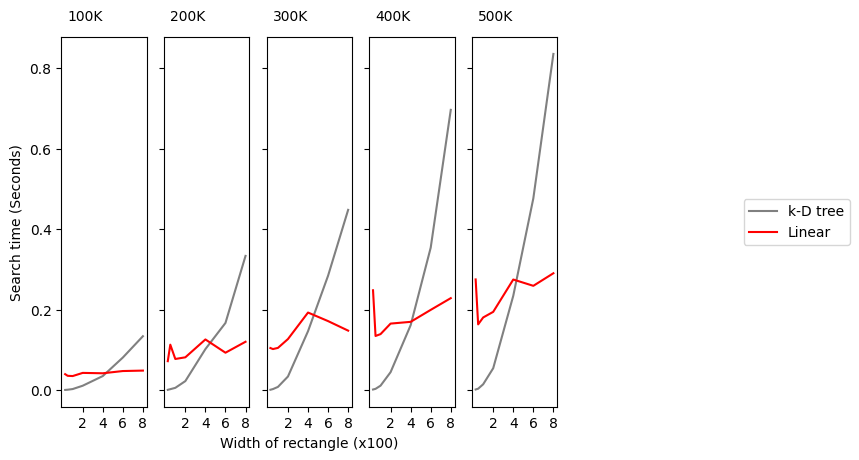

In [33]:
sizes = list(new_data.keys())

panel_label_y = 1.1 * max(new_data[sizes[-1]][1]) # get Y position of panel labels

_, axs = plt.subplots(1, len(sizes), sharey=True)

for i in range(len(sizes)):
    w = sizes[i]
    axs[i].plot(new_data[w][0], new_data[w][1], color='grey', label='k-D tree')
    axs[i].plot(new_data[w][0], new_data[w][2], color='r', label='Linear')
    #plt.xticks([sizes[j]/100 for j in range(len(sizes)) if j%3==0])
    axs[i].xaxis.set_ticks([2, 4, 6, 8])
    axs[i].text(0.5, panel_label_y, f'{w//1000}K')

axs[2].set_xlabel('Width of rectangle (x100)')
axs[0].set_ylabel('Search time (Seconds)')
plt.legend(loc='right', bbox_to_anchor=(4.5, 0.5))
plt.show()

## 3. Performance of nearest neighbor search

Now we test the performance of nearest neighbor search using three methods: k-D tree, point quadtree, and linear search (`nn_linear`). We did not discuss nearest neighbor search the class in this semester, but the algorithms are similar to those of orthogonal and circular searches. Please refer to Sections 5.1.3 and 6.2 of *GIS Algorithms* for more detailed discussions about nearest neighbor search.

Here are some necessary functions for the testing.

In [34]:
def nn_linear(p, points, n_neighbor=10):
    '''Linear search, or exhaustive search, or brute-force search'''
    dist = [p.distance(z) for z in points]
    Z1 = [(points[i], dist[i]) for i in range(len(dist))]
    Z1.sort(key=lambda Z1: Z1[1])
    Z1 = Z1[:n_neighbor]
    return Z1

def test_nn_find(rect=[[10,1000], [10,1000]], npts=100, n_neighbor=10, n_query=10):
    '''
    Tests the performance of nearest neighbor search using a balanced k-D tree,
    a point quadtree, and the brute force approach. The brute-force approach (linear search)
    is done using the above function called nn_linear.

    INPUT
        rect        - a list of lists defining the rectangle as [ [xmin, xmax], [ymin, ymax] ]
        npts        - the number of points to search from
        n_neighbor  - the number of neighbors to find
        n_query     - number of times to repeat the search

    OUTPUT
        check the code and text (answer this in Question 3 below)
    '''
    randpoints0 = [rand_point(rect) for i in range(npts)]
    randpoints = copy.deepcopy(randpoints0)
    pqt = pointquadtree(randpoints0)
    kdt = kdtree2(randpoints0)

    times = []
    for i in range(n_query):
        p = rand_point(rect)
        t1 = time.time()
        nnp1 = kdtree_nearest_neighbor_query(kdt, p, n_neighbor)
        t2 = time.time()
        nnp2 = pq_nearest_neighbor_query(pqt, p, n_neighbor)
        t3 = time.time()
        nnp3 = nn_linear(p, randpoints, n_neighbor) # use points in the original order
        t4 = time.time()
        times.append((t2-t1, t3-t2, t4-t3))
    return sum([t[0] for t in times])/n_query, sum([t[1] for t in times])/n_query, sum([t[2] for t in times])/n_query


In [35]:
test_nn_find(n_neighbor=25, npts=10000)

(0.0005220174789428711, 0.0015065193176269532, 0.011396980285644532)

Now we test a few configurations. We search for up to 800 nearest points (note this is not the same as 800 in the previous experiment where 800 is the width of the rectangle). In our tests below, 800 points is really a small portion of all points. More on this later.

In [37]:
%%time
results_nn = []
for npts in range(200000, 500001, 200000):
    for n in [25, 50, 100, 200, 400, 800]:
        x = test_nn_find(npts=npts, n_neighbor=n)
        x = npts, n, x[0], x[1], x[2]
        results_nn.append(x)
        print(x)

(200000, 25, 0.0005693435668945312, 0.0021558046340942384, 0.6700874328613281)
(200000, 50, 0.0014142513275146485, 0.007755827903747558, 0.9251448631286621)
(200000, 100, 0.0028603315353393556, 0.015782785415649415, 0.7581611394882202)
(200000, 200, 0.008814811706542969, 0.04742920398712158, 0.8316965103149414)
(200000, 400, 0.031425070762634275, 0.16864256858825682, 0.6849819660186768)
(200000, 800, 0.09975473880767823, 0.6146340370178223, 0.7955633878707886)
(400000, 25, 0.0007032632827758789, 0.0015465974807739257, 1.46770179271698)
(400000, 50, 0.0013031959533691406, 0.005747771263122559, 1.546008324623108)
(400000, 100, 0.002826499938964844, 0.012560868263244629, 1.46578950881958)
(400000, 200, 0.00796351432800293, 0.04069411754608154, 1.546984314918518)
(400000, 400, 0.029617738723754884, 0.12413530349731446, 1.8174064397811889)
(400000, 800, 0.11242766380310058, 0.6039106607437134, 1.6524141073226928)
CPU times: user 6min 20s, sys: 2.52 s, total: 6min 23s
Wall time: 6min 25s


## <font color="red">Question 4</font>

Plot a figure that can show the time complexity trend of nearest neighbor search using a tree (a k-D tree, a point quadtree, or both) from the above experiment. Use the data in `results_nn` to do this. We can use something very similar to the previous section, but note now we have three times, k-D tree, quadtree, and linear search, respectively.

Generally, finding 800 nearest neighbors of a point on a tree of 900,000 points is a piece of cake! However, before we can be more conclusive, there are more tests to do: what is the downside of using a k-D tree? We know that constructing such a tree takes time, and from the previous experiments, we also know that at some point the use of a k-D tree for searching may be excessive because we will have to traverse the tree back and forth too many times that will be more than just using a linear search. Does this happen to the nearest neighbor search using k-D tree too? Here are some quick tests and these should give us some good ideas about the last point!

In [ ]:
%%time
print(test_nn_find(npts=100000, n_neighbor=10))
print(test_nn_find(npts=100000, n_neighbor=25))
print(test_nn_find(npts=100000, n_neighbor=10000))

We can do some similar tests, but on a much smaller data set (and therefore much smaller trees):

In [ ]:
%%time
print(test_nn_find(npts=250, n_neighbor=10))
print(test_nn_find(npts=250, n_neighbor=50))
print(test_nn_find(npts=250, n_neighbor=100))
print(test_nn_find(npts=250, n_neighbor=200))